# objectives - get basic model tested after variance inflation factor used for feature selection

- check feature importance afterwards, 

- set up for advanced model tuning 

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import datetime 
from joblib import dump, load 
import seaborn as sns

from utils import save_file

In [41]:
df = pd.read_csv('../../data/model/final_df.csv')
df.rename(columns={"Asian or Asian/Pacific Islander - female [Public School] 2020-21":'APA_F',
                  'Current\nExpense Per ADA':'Current_Expense_per_ADA'}
       ,inplace=True)
labels = df[['County_Name', 'District_Name', 'School_Name']].copy()
df.drop(columns=['Unnamed: 0','County_Name', 'District_Name', 'School_Name']
        ,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52665 entries, 0 to 52664
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Mean Scale Score                             52665 non-null  float64
 1   Total Tested with Scores at Reporting Level  52665 non-null  float64
 2   Demographic Name                             52665 non-null  object 
 3   Student Group                                52665 non-null  object 
 4   District Type                                52665 non-null  object 
 5   Test ID                                      52665 non-null  object 
 6   School Type                                  52665 non-null  object 
 7   Education_type                               52665 non-null  object 
 8   Charter_School                               52665 non-null  int64  
 9   Low Grade                                    52665 non-null  object 
 10

In [3]:
df.head()

,Mean Scale Score,Total Tested with Scores at Reporting Level,Demographic Name,Student Group,District Type,Test ID,School Type,Education_type,Charter_School,Low Grade,...,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,Average Salary Paid,Current_Expense_per_ADA,est_num_u17_pov,Grocery_3mile,Grocery_dist
0,2579.7,106.0,All Students,All Students,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
1,2582.4,56.0,Male,Gender,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
2,2577.0,50.0,Female,Gender,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
3,2600.2,91.0,IFEP and EO (Initial fluent English proficient...,English-Language Fluency,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
4,2614.4,24.0,RFEP (Reclassified fluent English proficient),English-Language Fluency,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0


## Add random variable to compare variable inportance too 

In [8]:
## not used in final model 
# df['random'] = np.random.random(size = len(df))

## Decrease categories for one hote encoding 

In [42]:
df['Low Grade'] = df['Low Grade'].replace({'P':'K','5,4,3,2,1':'6',
                                           '11 or 8':'11,10,8',
                                          '10':'11,10,8'})

## One hot encode categotical columns 

In [43]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Low Grade']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Low Grade'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Low Grade',inplace=True,axis=1)
df.shape

(52665, 26)

In [44]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Test ID']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Test ID'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Test ID',inplace=True,axis=1)
df.shape

(52665, 26)

In [45]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Demographic Name']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Demographic Name'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Demographic Name',inplace=True,axis=1)
df.shape

(52665, 55)

In [46]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['District Type']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['District Type'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('District Type',inplace=True,axis=1)
df.shape

(52665, 58)

In [47]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Education_type']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Education_type'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Education_type',inplace=True,axis=1)
df.shape

(52665, 62)

## Final df shape 

In [48]:
df.shape

(52665, 62)

# Create X and y

In [49]:
X = df.drop(columns=['Mean Scale Score',
                # redundent columns 
                     'Student Group',  'School Type', ])
y = df['Mean Scale Score']
X.shape, y.shape

((52665, 59), (52665,))

## Save X with labels and y for predictions

In [50]:
## save x and y for later 

final = X.copy()
final['Mean Scale Score'] = y
final[['County_Name', 'District_Name', 'School_Name']] = labels[['County_Name', 'District_Name', 'School_Name']]

print(final.shape)
final.to_csv('../../data/model/XY_final.csv')

(52665, 63)


In [16]:
 X_train, X_test, y_train, y_test = train_test_split(  X, y ,
                         test_size=0.2, random_state=42)
    
    

## Create pipeline for linear model 

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [13]:
lm = LinearRegression().fit(X_tr_scaled,y_train)

In [14]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [15]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.6545051475563155, 0.6541179443668361)

In [16]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(35.03851890791086, 34.91477468215217)

In [17]:
X_train.shape

(42132, 59)

In [24]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression,k=40),
    LinearRegression()
)

In [25]:
pipe.fit(X_train,y_train)
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [26]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6447161596229172, 0.644658839470919)

In [27]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(35.48161211596395, 35.39462084529474)

In [28]:
cv_results = cross_validate(pipe, X_train,y_train, cv=5)
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.6433582769836337, 0.005685183939547486)

# Linear model output 
## Cross validation does not increase r2 , small variation between models 

## look to use grid search on number of features for hypter paramter tuning 

In [19]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [22]:
lr_grid_cv = GridSearchCV(pipe,param_grid= grid_params, cv=5, n_jobs=-1)

In [23]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7ff459ccb310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [24]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [25]:
lr_grid_cv.best_params_

{'selectkbest__k': 59}

In [26]:
lr_grid_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=59,
                             score_func=<function f_regression at 0x7ff459ccb310>)),
                ('linearregression', LinearRegression())])

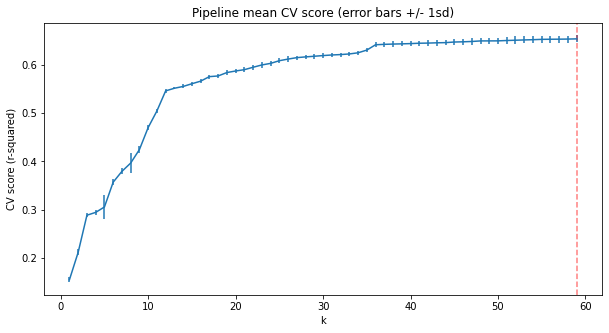

In [27]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

# Linear model wants to use all of the features for best cv score 

In [28]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
# pd.Series(coefs, index=features).sort_values(ascending=False)

In [29]:
coefficients = pd.DataFrame(coefs, 
     index = features, columns =['coef']).sort_values(by='coef',ascending=False)
coefficients

,coef
FTE_Teachers,14.724981
Avg_21,12.941773
Pupil/Teacher-Ratio,12.824476
Demographic Name_Asian,11.465370
Demographic Name_Graduate school/Post graduate,7.834904
Demographic Name_IFEP (Initial fluent English proficient),7.146550
APA_F,6.123609
Demographic Name_White,5.718732
Total Tested with Scores at Reporting Level,5.635695
Demographic Name_Filipino,5.365865


## Some continuous features associated with higher score predictions 
- Full time Educators (FTE)
- Average housing price of zip code 2021
- pupil teacher ratio
- post graduate parent eductiion 

## Some categorical features associated with lower score predictions from the one hot enocded education type, demographic name and school population features. 
- Continuation School , county community school Juvenile court school
- Math test ( vs ELA)
- reported disabilities , EL groups  
- free meal count 

# Random forest Modeling 
- modeing with df baggin model 

In [31]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

             

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [32]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))


R^2 Training Score: 0.99 
OOB Score: 0.93 
R^2 Validation Score: 0.93


In [33]:
y_te_rf_pred=rf.predict(X_test)

In [34]:
r2_score(y_test,y_te_rf_pred)

0.9295519879912157

In [35]:
median_mae = mean_absolute_error(y_train, rf.predict(X_train)), mean_absolute_error(y_test, y_te_rf_pred)
median_mae



(4.959606862408242, 13.11583754677283)

## Standard rf model score 
- rf model off by 5 points on training and 13 on testing, 2.6 times better score than linear model 

## Visulising feature importance 

In [36]:
# https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    fig ,ax = plt.subplots(figsize=(12,12))
    fig = sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
    sns.despine()

In [37]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp[:20]

,feature,feature_importance
0,Education_type_Continuation School,0.155317
1,APA_F,0.127494
2,Avg_21,0.068829
3,Hispanic_Female,0.061937
4,Pupil/Teacher-Ratio,0.058074
5,Test ID_Mathematics,0.054507
6,Demographic Name_Reported disabilities,0.047472
7,Free_Meal_count,0.043579
8,Demographic Name_EL (English learner),0.037050
9,Demographic Name_ELs enrolled 12 months or more,0.036406


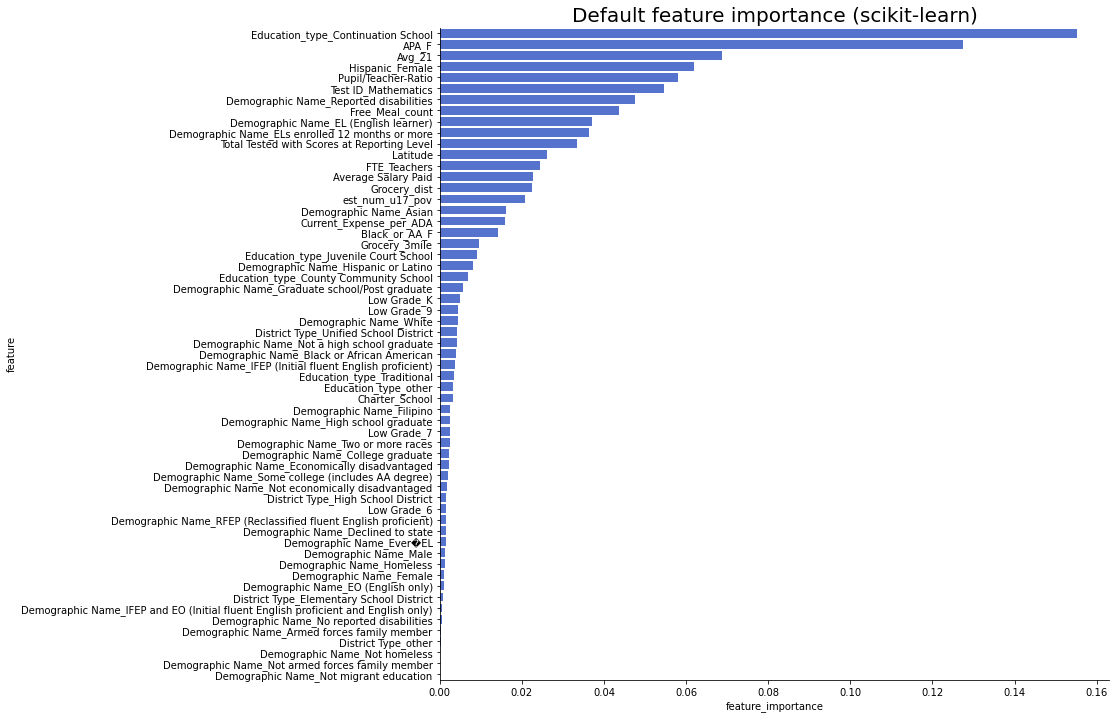

In [38]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

## RF pipeline for hyperparamter tuning 

In [17]:
rf_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
    )

In [7]:
rf_cv_results = cross_validate(rf_pipe, X_train, y_train, cv =5)


In [20]:
rf_cv_scores = rf_cv_results['test_score']
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9247635004925936, 0.0024999991210266494)

In [21]:
n_est = [int(n) for n in np.logspace(1,3,10)]
n_est[:8]

[10, 16, 27, 46, 77, 129, 215, 359]

In [22]:
grid_params = {
    'randomforestregressor__n_estimators': n_est[:5],
    'randomforestregressor__max_depth':[None,2,3,4,6]    
}

In [23]:
rf_grid_cv = GridSearchCV(rf_pipe, param_grid= grid_params, cv=5, n_jobs=-1)


In [24]:
rf_grid_cv.fit(X_train,y_train)
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__n_estimators': 77}

In [25]:
rf_grid_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=77))])

In [26]:
results = cross_validate(rf_grid_cv.best_estimator_,
                         X_train, y_train, cv =5)
scores = results['test_score']
np.mean(scores), np.std(scores)

(0.9244291370915988, 0.0029472593989567737)

In [27]:
y_te_grid_rf_pred = rf_grid_cv.best_estimator_.predict(X_test)

In [28]:
median_mae = mean_absolute_error(y_train, 
                rf_grid_cv.best_estimator_.predict(X_train)),mean_absolute_error(y_test, y_te_grid_rf_pred)
median_mae

(4.974024099891389, 13.112081604881537)

# Grid search and basic random forest model have almost same mean Absolute error and R2 score 

In [51]:
# rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_

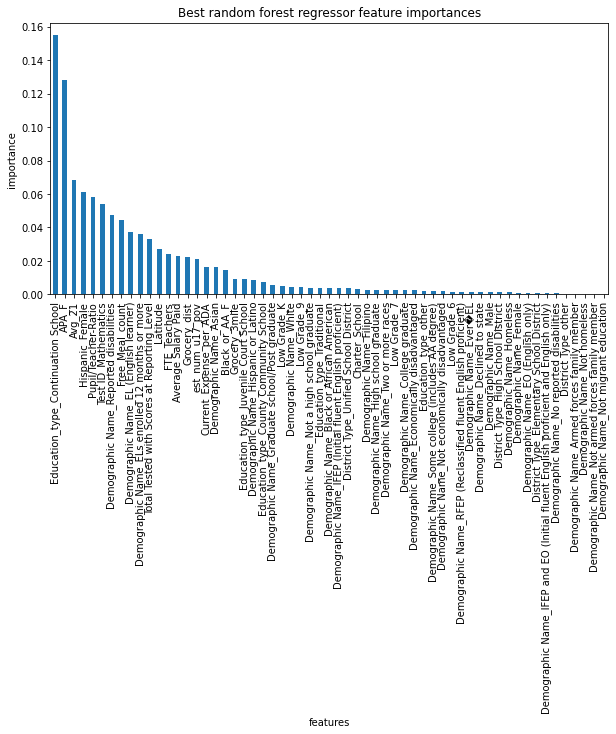

In [52]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

# AdaBoost Model 
- testing if boosting outperforms random forest bagging  

In [12]:

ada = AdaBoostRegressor(DecisionTreeRegressor(),
                        random_state=42)



In [35]:
n_est = [int(n) for n in np.logspace(1,3,10)]

grid_params = {
    'Regressor__n_estimators': n_est[:5],
   'Regressor__base_estimator__max_depth':[None,2,3,4,5]    
}

In [102]:
# ada_pipe.get_params()

In [36]:
ada_pipe = Pipeline([
    ('scaling',StandardScaler()),
   
    ('Regressor',AdaBoostRegressor(DecisionTreeRegressor(),
                        random_state=42))])

In [37]:

ada_grid_cv = GridSearchCV(ada_pipe, param_grid= grid_params,
                          cv=5, n_jobs=-1)

In [38]:
ada_grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('Regressor',
                                        AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'Regressor__base_estimator__max_depth': [None, 2, 3, 4,
                                                                  5],
                         'Regressor__n_estimators': [10, 16, 27, 46, 77]})

In [39]:
ada_grid_cv.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()),
                ('Regressor',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                   n_estimators=46, random_state=42))])

In [40]:
results = cross_validate(ada_grid_cv.best_estimator_,
                         X_train, y_train, cv =5)
scores = results['test_score']
np.mean(scores), np.std(scores)

(0.9194251925977923, 0.003134578806894644)

In [41]:
train_pred =ada_grid_cv.best_estimator_.predict(X_train)
y_te_ada_pred = ada_grid_cv.best_estimator_.predict(X_test)
mae_train = mean_absolute_error(y_train,train_pred)
mae_test = mean_absolute_error(y_test, y_te_ada_pred)

print(mae_train, mae_test)

2.9864535588831713 13.624117453768873


## AdaBoost model does not outperfrom random forest model 
- lower R2 score
- greater test mean_absolute error 

# Use select from model to remove features below random threshold to simplify model 

In [67]:
from sklearn.feature_selection import SelectFromModel


In [68]:
model = SelectFromModel(rf, 
                        threshold=0.012,
                        # should remove random and all below 
                       )

In [69]:
model.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                                random_state=42),
                threshold=0.012)

In [70]:
selected_feat = X_train.columns[(model.get_support())]
selected_feat

Index(['Total Tested with Scores at Reporting Level', 'Free_Meal_count',
       'Latitude', 'FTE_Teachers', 'Pupil/Teacher-Ratio', 'Hispanic_Female',
       'Black_or_AA_F', 'APA_F', 'Avg_21', 'Average Salary Paid',
       'Current_Expense_per_ADA', 'est_num_u17_pov', 'Grocery_dist',
       'Test ID_Mathematics', 'Demographic Name_Asian',
       'Demographic Name_EL (English learner)',
       'Demographic Name_ELs enrolled 12 months or more',
       'Demographic Name_Reported disabilities',
       'Education_type_Continuation School'],
      dtype='object')

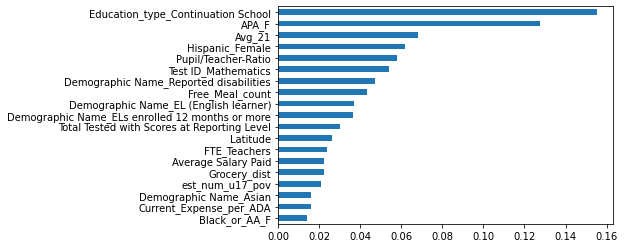

In [71]:
importances = pd.Series(model.estimator_.feature_importances_,
          index=X_train.columns).sort_values(ascending=False)
importances[selected_feat].sort_values().plot(kind='barh')
plt.show()

## of cultural groups asain pacific islanders and hispanics have the highest feature importances in the model 

##  Of features not associated by economic group model can be tested to see what change in average housing price, pupil teacher ratio , free meal count, average salary paid and fte teachers effects different schools in the same district when changes in these featuers are modeled. 

In [72]:
new_X_tr = model.transform(X_train)
new_X_te = model.transform(X_test)

In [102]:
new_X = model.transform(X)
new_X = pd.DataFrame(new_X, columns = selected_feat)
new_X.shape

(52665, 19)

In [104]:
new_X.head()

,Total Tested with Scores at Reporting Level,Free_Meal_count,Latitude,FTE_Teachers,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,Average Salary Paid,Current_Expense_per_ADA,est_num_u17_pov,Grocery_dist,Test ID_Mathematics,Demographic Name_Asian,Demographic Name_EL (English learner),Demographic Name_ELs enrolled 12 months or more,Demographic Name_Reported disabilities,Education_type_Continuation School
0,106.0,230.0,37.657668,74.847305,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,1372.0,0.0,0.0,0.0,0.0,0.0,0.0
1,56.0,230.0,37.657668,74.847305,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,1372.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50.0,230.0,37.657668,74.847305,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,1372.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.0,230.0,37.657668,74.847305,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,1372.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,230.0,37.657668,74.847305,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,1372.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
new_X.to_csv('../../data/model/final_feature_X.csv')

In [73]:
new_X_tr.shape

(42132, 19)

In [80]:
rf_pipe.fit(new_X_tr,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [81]:
print('R^2 Training Score: {:.2f}  \nR^2 Validation Score: {:.2f}'.format(rf_pipe.score(new_X_tr, y_train), 
#                                                                                              rf_pipe.oob_score_,
                                                                                             rf_pipe.score(new_X_te, y_test)))


R^2 Training Score: 0.98  
R^2 Validation Score: 0.87


In [92]:
# rf_grid_cv.fit(new_X_tr,y_train)
# rf_grid_cv.best_params_

## Simplified model lost 6 % training r2 score but only usues 19 features instead of 65  

gridsearch cv could be run on new cut down set to see if model performance can be increased 

In [32]:
rf_grid_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=77))])

In [33]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [72]:
from utils import save_file

In [34]:
modelpath = '../../models'
save_file(best_model, '11th_grade_scoring_model.pkl', modelpath)

A file already exists with this name.



Do you want to overwrite? (Y/N) Y


Writing file.  "../../models/11th_grade_scoring_model.pkl"
